In [4]:
import os
from random import shuffle
from torchvision.transforms import ToPILImage
import torchvision.transforms as transforms
from torchvision import datasets, utils
import pickle
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch import utils
from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
%matplotlib inline

## Estimate the Scale Parameters

In [5]:
import glob
import random
import PIL
if not os.path.exists("statistics.pkl"):
    files = glob.glob("images/**/*.jpg")
    subset = random.choices(files, k=3000)
    images = []
    for im in subset:
        with PIL.Image.open(im) as f:
            images.append(np.asarray(f) / 256)
    arr = np.stack(images)
    mean = arr.mean(axis=(0, 1, 2))
    std = arr.std(axis=(0, 1, 2))
    with open('statistics.pkl', 'wb+') as stat:
        pickle.dump((mean, std), stat)
else:
    with open('statistics.pkl', 'rb') as stat:
        print("READING")
        mean, std = pickle.load(stat)
print(mean, std)


READING
[0.42716227 0.45460954 0.44991944] [0.2543999  0.2460573  0.27638961]


## Setting up Training Procedure

In [6]:
batch_size = 4
num_workers = 2

In [7]:
secret_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        'images/',
        transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean,
                                 std=std)
        ])), batch_size=batch_size, num_workers=num_workers,
    pin_memory=True, shuffle=True, drop_last=True)
cover_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        'images/',
        transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean,
                                 std=std)
        ])), batch_size=batch_size, num_workers=num_workers,
    pin_memory=True, shuffle=True, drop_last=True)


In [8]:
import network
import importlib
importlib.reload(network)


<module 'network' from 'c:\\Users\\binhe\\Documents\\steg\\network.py'>

In [9]:
mixed_network = network.MixedNet()

In [28]:
def train_model(net, secret_loader, cover_loader, beta, learning_rate, num_epochs=1):

    # Save optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    loss_history = []
    # Iterate over batches performing forward and backward passes
    for epoch in range(num_epochs):

        # Train mode
        net.train()

        train_losses = []
        # Train one epoch
        for idx, (train_secret, train_cover) in enumerate(zip(secret_loader, cover_loader)):
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            # this is the cover the recovered secret
            train_hidden, train_output = net(train_secret[0], train_cover[0])
            
            # Calculate loss and perform backprop
            train_loss, train_loss_cover, train_loss_secret = network.customized_loss(
                train_output, train_hidden, train_secret[0], train_cover[0], beta)
            train_loss.backward()
            optimizer.step()

            # Saves training loss
            train_losses.append(train_loss.item())
            loss_history.append(train_loss.item())

            # Prints mini-batch losses
            print('Training: Batch {0}/{1}. Loss of {2:.4f}, cover loss of {3:.4f}, secret loss of {4:.4f}'.format(
                idx+1, len(secret_loader), train_loss.item(), train_loss_cover.item(), train_loss_secret.item()))
            if idx > 10:
                break

        torch.save(net, 'models/epoch-N{}.pkl'.format(epoch+1))

        mean_train_loss = np.mean(train_losses)

        # Prints epoch average loss
        print('Epoch [{0}/{1}], Average_loss: {2:.4f}'.format(
            epoch+1, num_epochs, mean_train_loss))

    return net, mean_train_loss, loss_history


In [12]:
learning_rate = 0.001
beta = 0

In [29]:
mixed_network, mean_train_loss, loss_history = train_model(mixed_network, secret_loader, cover_loader, beta, learning_rate)

c:\Users\binhe\Documents\steg\hiding_network.py:9: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = torch.nn.init.normal(torch.Tensor(tensor.size()), 0, 0.1)


Training: Batch 1/1344. Loss of 199.4480, cover loss of 199.4480, secret loss of 2.1859
Training: Batch 2/1344. Loss of 8676211712.0000, cover loss of 8676211712.0000, secret loss of 113558016.0000
Training: Batch 3/1344. Loss of 938.2957, cover loss of 938.2957, secret loss of 8.3736
Training: Batch 4/1344. Loss of 3971.0762, cover loss of 3971.0762, secret loss of 14.6042
Training: Batch 5/1344. Loss of 19689.5977, cover loss of 19689.5977, secret loss of 65.5793
Training: Batch 6/1344. Loss of 28425.2949, cover loss of 28425.2949, secret loss of 86.3642
Training: Batch 7/1344. Loss of 257738.0625, cover loss of 257738.0625, secret loss of 775.5270
Training: Batch 8/1344. Loss of 203144.9219, cover loss of 203144.9219, secret loss of 585.8123
Training: Batch 9/1344. Loss of 202870.2500, cover loss of 202870.2500, secret loss of 616.2526
Training: Batch 10/1344. Loss of 146013.3906, cover loss of 146013.3906, secret loss of 458.8264
Training: Batch 11/1344. Loss of 36024.1758, cover l

In [69]:
original_network = network.OriginalNet()

In [70]:
original_network, mean_train_loss, loss_history = train_model(original_network, secret_loader, cover_loader, beta, learning_rate)

tensor(0.7433, grad_fn=<MseLossBackward>) tensor(0.7433, grad_fn=<MeanBackward0>)
Training: Batch 1/1344. Loss of 1.7456, cover loss of 0.7433, secret loss of 1.0024
tensor(4.3730e+11, grad_fn=<MseLossBackward>) tensor(4.3730e+11, grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [57]:
def denormalize(image, std, mean):
    ''' Denormalizes a tensor of images.'''

    for t in range(3):
        image[t, :, :] = (image[t, :, :] * std[t]) + mean[t]
    return image

In [56]:
original_network.eval()

secret = next(iter(secret_loader))
cover = next(iter(cover_loader))

NameError: name 'original_network' is not defined

In [59]:
hidden, reveal = original_network(secret[0][0, :, :, :].unsqueeze(0), cover[0][0, :, :, :].unsqueeze(0))

In [58]:
mixed_network.eval()

secret = next(iter(secret_loader))
cover = next(iter(cover_loader))

In [39]:
hidden, reveal = mixed_network(secret[0][0, :, :, :].unsqueeze(0), cover[0][0, :, :, :].unsqueeze(0))

c:\Users\binhe\Documents\steg\hiding_network.py:9: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = torch.nn.init.normal(torch.Tensor(tensor.size()), 0, 0.1)


In [40]:
hidden.shape

torch.Size([1, 3, 256, 256])

In [41]:
std, mean

(array([0.2543999 , 0.2460573 , 0.27638961]),
 array([0.42716227, 0.45460954, 0.44991944]))

In [42]:
hidden

tensor([[[[ 1.2315,  1.6806,  1.9574,  ...,  0.6395,  0.5726,  0.4468],
          [ 1.6495,  2.2928,  2.6836,  ...,  0.8459,  0.7611,  0.5905],
          [ 1.9506,  2.7412,  3.2655,  ...,  1.0245,  0.9066,  0.7071],
          ...,
          [ 0.6243,  0.8451,  1.0010,  ...,  0.9078,  0.7796,  0.5947],
          [ 0.5419,  0.7313,  0.8452,  ...,  0.7836,  0.6754,  0.5172],
          [ 0.4080,  0.5475,  0.6296,  ...,  0.6077,  0.5239,  0.4113]],

         [[-0.9210, -1.2983, -1.5361,  ..., -0.6100, -0.5639, -0.4464],
          [-1.2478, -1.7874, -2.1171,  ..., -0.8254, -0.7704, -0.6104],
          [-1.4536, -2.0919, -2.5126,  ..., -0.9657, -0.8906, -0.7095],
          ...,
          [-0.4934, -0.6946, -0.8289,  ..., -0.7722, -0.6993, -0.5564],
          [-0.4372, -0.6103, -0.7104,  ..., -0.6760, -0.6157, -0.4868],
          [-0.3271, -0.4538, -0.5242,  ..., -0.5148, -0.4656, -0.3697]],

         [[-1.5521, -2.1714, -2.5094,  ..., -0.7730, -0.6830, -0.5118],
          [-2.1409, -3.0529, -

In [43]:
hidden = denormalize(hidden.squeeze(0), std, mean)
reveal = denormalize(reveal.squeeze(0), std, mean)

In [44]:
hidden

tensor([[[ 0.7405,  0.8547,  0.9251,  ...,  0.5899,  0.5728,  0.5408],
         [ 0.8468,  1.0104,  1.1099,  ...,  0.6424,  0.6208,  0.5774],
         [ 0.9234,  1.1245,  1.2579,  ...,  0.6878,  0.6578,  0.6070],
         ...,
         [ 0.5860,  0.6422,  0.6818,  ...,  0.6581,  0.6255,  0.5784],
         [ 0.5650,  0.6132,  0.6422,  ...,  0.6265,  0.5990,  0.5587],
         [ 0.5310,  0.5664,  0.5873,  ...,  0.5818,  0.5604,  0.5318]],

        [[ 0.2280,  0.1352,  0.0766,  ...,  0.3045,  0.3159,  0.3448],
         [ 0.1476,  0.0148, -0.0663,  ...,  0.2515,  0.2650,  0.3044],
         [ 0.0969, -0.0601, -0.1636,  ...,  0.2170,  0.2355,  0.2800],
         ...,
         [ 0.3332,  0.2837,  0.2507,  ...,  0.2646,  0.2825,  0.3177],
         [ 0.3470,  0.3044,  0.2798,  ...,  0.2883,  0.3031,  0.3348],
         [ 0.3741,  0.3430,  0.3256,  ...,  0.3279,  0.3400,  0.3636]],

        [[ 0.0209, -0.1502, -0.2436,  ...,  0.2363,  0.2611,  0.3085],
         [-0.1418, -0.3939, -0.5274,  ...,  0

In [38]:
secret[0]

tensor([[[[ 1.1765e-02,  0.0000e+00,  7.8431e-03,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  3.9216e-03],
          [ 3.9216e-03,  0.0000e+00,  0.0000e+00,  ...,  7.8431e-03,
            7.8431e-03,  7.8431e-03],
          ...,
          [ 1.0980e-01,  3.1373e-02,  9.4118e-02,  ...,  2.7059e-01,
            2.3529e-01,  2.0784e-01],
          [ 4.7059e-02,  3.9216e-02,  1.7255e-01,  ...,  2.5098e-01,
            2.5098e-01,  1.9216e-01],
          [ 7.8431e-02,  1.1373e-01,  1.5686e-01,  ...,  2.7059e-01,
            2.9020e-01,  2.5098e-01]],

         [[ 3.8824e-01,  3.7255e-01,  3.8431e-01,  ...,  2.5882e-01,
            2.5882e-01,  2.5490e-01],
          [ 3.7255e-01,  3.7647e-01,  3.7255e-01,  ...,  2.6667e-01,
            2.5882e-01,  2.5882e-01],
          [ 3.8039e-01,  3.6863e-01,  3.6863e-01,  ...,  2.6667e-01,
            2.5490e-01,  2.5490e-01],
          ...,
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


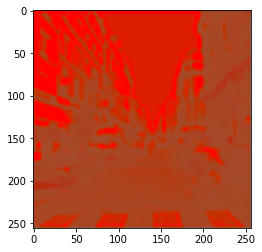

In [51]:
plt.imshow(hidden.detach().numpy().transpose([1, 2, 0]))

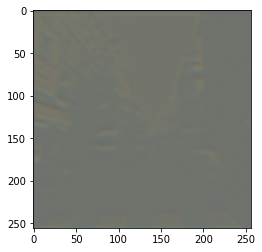

In [52]:
plt.imshow(reveal.detach().numpy().transpose([1, 2, 0]))

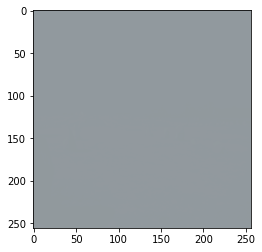

In [53]:
plt.imshow(denormalize(secret[0][0], std, mean).detach().numpy().transpose([1, 2, 0]))

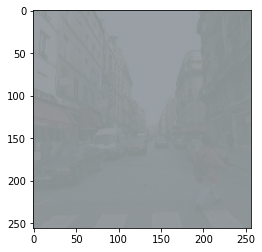

In [54]:
plt.imshow(denormalize(cover[0][0], std, mean).numpy().transpose([1, 2, 0]))

In [63]:
torch.fft.fft2(cover[0]).shape

torch.Size([4, 3, 256, 256])